# Workflow figure

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yaml
import glob
import obspy
import sys
import os
import scipy.signal as sp
import matplotlib.image as mpimg

import h5py
from matplotlib.gridspec import GridSpec
sys.path.append('../src/')
from f2_cluster_functions import getSgram, getFP, getWF


yamlPath = "/Users/theresasawi/Documents/11_Manuscripts/Methods_Paper/data/yaml/demo_150Hz_v3.yaml"




In [2]:
import scipy.signal as sp

def makeSgram(data,fs,nperseg,noverlap,nfft, scaling, mode,fmin,fmax,decimation_factor=5):        
    

    fSTFT, tSTFT, STFT_raw = sp.spectrogram(x=data,
                                                fs=fs,
                                                nperseg=nperseg,
                                                noverlap=noverlap,
                                                #nfft=Length of the FFT used, if a zero padded FFT is desired
                                                nfft=nfft,
                                                scaling=scaling,
                                                axis=-1,
                                                mode=mode)


    freq_slice = np.where((fSTFT >= fmin) & (fSTFT <= fmax))
    #  keep only frequencies within range
    fSTFT   = fSTFT[freq_slice]
    STFT_0 = STFT_raw[freq_slice,:][0]




    ### Average pooling [Eric Beauce, 2022]
    trimmed_length = (STFT_0.shape[-1]//decimation_factor)*decimation_factor
    shape_for_pooling = tuple(STFT_0.shape[:-1]) + tuple((-1, decimation_factor))
    STFT_0 = np.mean(STFT_0[..., :trimmed_length].reshape(shape_for_pooling), axis=-1)
    tSTFT = tSTFT[:trimmed_length][::decimation_factor]   
    
    return tSTFT, fSTFT, STFT_0

# Load things

In [3]:
###########################################################


# yamlPath = "/Users/theresasawi/Documents/11_Manuscripts/Methods_Paper/data/yaml/demo_150Hz.yaml"



with open(yamlPath) as stream:
    config = yaml.safe_load(stream)
    
path_config = config["paths"]
key = path_config["key"]
print("Project key:", key)


# build path strings
dataH5_name = f'data_{key}.h5'
projectPath = path_config["projectPath"]
SpecUFEx_H5_name = 'SpecUFEx_' + path_config["h5name"] #f'SpecUFEx_{key}.hdf5'
SpecUFEx_H5_path = projectPath + 'data/H5files/' + SpecUFEx_H5_name
path_waveform = path_config["waveformPath"]
dataH5_path = projectPath + 'data/H5files/' + dataH5_name


wf_list = glob.glob(path_waveform + '/*')
wf_list.sort()

filenames = wf_list
ev_ID = [path.split('/')[-1] for path in wf_list]



cat_paths = pd.DataFrame({"ev_ID":ev_ID,
                          "filename":wf_list})

iii = 0
wf_test = obspy.read(cat_paths.filename.iloc[iii])
lenData = len(wf_test[0].data)
fs = wf_test[0].stats.sampling_rate

print('Example evID: ', ev_ID[iii])


#Spectrogram parameters
sgram_config = config['sgramParams']
fmin = sgram_config['fmin']               
fmax = sgram_config['fmax']               
winLen_Sec = sgram_config['winLen_Sec']
fracOverlap = sgram_config['fracOverlap']
nfft = sgram_config['nfft']




nperseg = int(sgram_config["winLen_Sec"]*fs) #datapoints per window segment
noverlap = int(nperseg*sgram_config["fracOverlap"])  #fraction of window overlapped  

#padding must be longer than n per window segment
if nfft < nperseg:
    nfft = nperseg*2
    print("nfft too short; changing to ", nfft)

mode='magnitude'
scaling='spectrum'


# set args for generator
args = {'fs': fs,
        'lenData': lenData,
        'nperseg': nperseg,
        'noverlap': noverlap,
        'nfft': nfft,
        'mode': mode,
        'scaling': scaling,
        'fmin': fmin,
        'fmax': fmax
       }


print(args)



Project key: demo_150Hz_v3
Example evID:  SQK.BG.DPZ..D.2012.001.194545
{'fs': 500.0, 'lenData': 10000, 'nperseg': 250, 'noverlap': 62, 'nfft': 2048, 'mode': 'magnitude', 'scaling': 'spectrum', 'fmin': 1, 'fmax': 150}


(0.0, 10000.0)

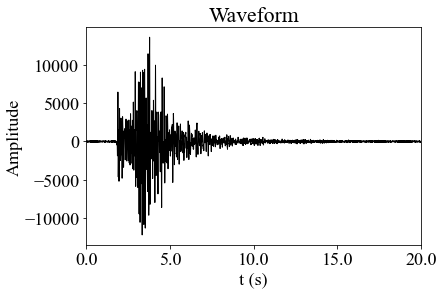

In [18]:
evID = ev_ID[iii]

wf = getWF(evID,dataH5_path)

ax1 = plt.gca()
ax1.plot(wf,lw=1,color='k')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('Amplitude',labelpad=1)
ax1.set_xticks(np.linspace(0,len(wf),5))
ax1.set_xticklabels(np.linspace(0,20,5))
ax1.set_title('Waveform')
ax1.set_xlim(0,len(wf))

### Non-normed/neg Sgram

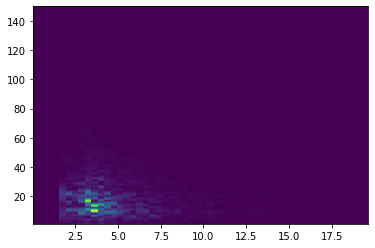

In [5]:
mode='magnitude'
scaling='spectrum'

tSTFT0, fSTFT0, sgram0 = makeSgram(wf,fs,nperseg,noverlap,nfft, scaling, mode,fmin,fmax,decimation_factor=1)
plt.pcolormesh(tSTFT0, fSTFT0, sgram0)

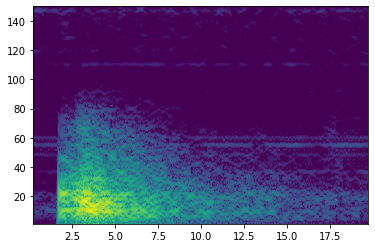

In [6]:
tSTFT, fSTFT, sgram = getSgram(evID,SpecUFEx_H5_path)

plt.pcolormesh(tSTFT, fSTFT, sgram)

In [7]:
len(tSTFT), len(fSTFT)

(1950, 610)

In [8]:

with h5py.File(SpecUFEx_H5_path,'r') as fileLoad:


    ACM = fileLoad["SpecUFEX_output/ACM"][evID][()]
    STM = fileLoad["SpecUFEX_output/STM"][evID][()]

    gain = fileLoad["SpecUFEX_output/ACM_gain/gain"][()]
    
    W    = fileLoad["SpecUFEX_output/W/W"][()]
    EB   = fileLoad["SpecUFEX_output/EB/SQK.BG.DPZ..D.2014.365.205653"][()]

    fp = fileLoad["fingerprints/"][evID][()]
    
    

(-0.5, 2421.5, 783.5, -0.5)

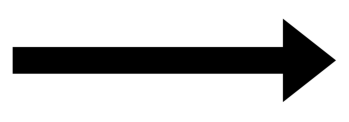

In [9]:

# Load the image using matplotlib's imread() function
arrow_image = mpimg.imread('../reports/figures/arrow.png')
approx_image = mpimg.imread('../reports/figures/approx2.png')
dot_image = mpimg.imread('../reports/figures/dot.png')
ax0 = plt.gca()
ax0.imshow(arrow_image)
ax0.axis('off')  # Turn off axis labels and ticks


# Figure Workflow

In [10]:
tSTFT

array([  0.25,   0.26,   0.27, ...,  19.72,  19.73,  19.74])

In [11]:
wf

array([  4.28, -19.72,  -5.72, ..., -50.72, -67.72,  -3.72])

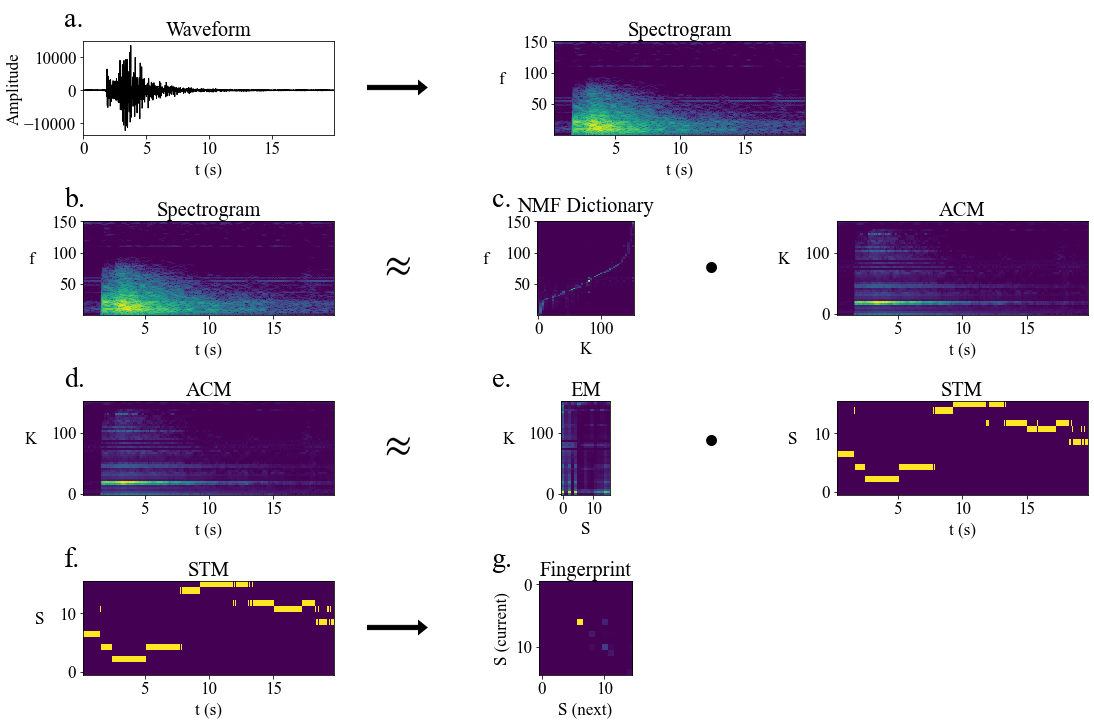

In [31]:
from matplotlib.ticker import FormatStrFormatter

width = 3.38583

plt.rcParams.update({'font.size': 17})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'


fig = plt.figure(figsize=(18,10))


##########################################################################################
##########################################################################################
##
## Row 1, Preprocessing: Waveform to Sgram to Normed Sgram
##
##########################################################################################
##########################################################################################

buff = .06
labelpad = 20

hs = .3
gs1 = GridSpec(1, 11, top=1-buff, bottom=0.75+buff, wspace=0.5, hspace= hs)
gs2 = GridSpec(1, 11, top=0.75-buff, bottom=0.5+buff, wspace=0.5, hspace= hs)
gs3 = GridSpec(1, 11, top=0.5-buff, bottom=0.25+buff, wspace=0.5, hspace= hs)
gs4 = GridSpec(1, 11, top=0.25-buff, bottom=buff, wspace=0.5, hspace= hs)


ax1 = fig.add_subplot(gs1[0,:3])
ax2 = fig.add_subplot(gs1[0,3:4])
ax3 = fig.add_subplot(gs1[0,5:8])
# ax4 = fig.add_subplot(gs1[0,7:8])
# ax5 = fig.add_subplot(gs1[0,8:11])


ax1.plot(wf,lw=1,color='k')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('Amplitude',labelpad=1)
ax1.set_xticks(np.linspace(0,len(wf),5)[0:-1])
ax1.set_xticklabels([str(int(f)) for f in np.linspace(0,20,5)][0:-1])
ax1.set_title('Waveform')
ax1.set_xlim(0,len(wf))
# ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))


ax2.imshow(arrow_image)
ax2.axis('off')

# ax3.pcolormesh(tSTFT0, fSTFT0, sgram0)
# ax3.set_ylabel('f',rotation=0,labelpad=labelpad)
# ax3.set_xlabel('t (s)')
# ax3.set_title('Spectrogram (raw)')

# ax4.imshow(arrow_image)
# ax4.axis('off')

ax3.pcolormesh(tSTFT, fSTFT, sgram)
ax3.set_ylabel('f',rotation=0,labelpad=labelpad)
ax3.set_xlabel('t (s)')
ax3.set_title('Spectrogram')

# ax4.axis('off')
# ax5.axis('off')


##########################################################################################
##########################################################################################
##
## Row 2, NMF:  Sgram to Dict x ACM
##
##########################################################################################
##########################################################################################

ax1b = fig.add_subplot(gs2[0,:3])
ax2b = fig.add_subplot(gs2[0,3:4])
ax3b = fig.add_subplot(gs2[0,4:7])
ax4b = fig.add_subplot(gs2[0,7:8])
ax5b = fig.add_subplot(gs2[0,8:11])

ax1b.pcolormesh(tSTFT, fSTFT, sgram)
ax1b.set_ylabel('f',rotation=0,labelpad=labelpad)
ax1b.set_xlabel('t (s)')
ax1b.set_title('Spectrogram')

ax2b.imshow(approx_image)
ax2b.axis('off')

ax3b.pcolormesh(np.linspace(0,fmax,ACM.shape[0]), fSTFT, W)
ax3b.set_ylabel('f',rotation=0,labelpad=labelpad)
ax3b.set_xlabel('K')
ax3b.set_title('NMF Dictionary',pad=10)
ax3b.set_aspect('equal')


# ax4b.imshow(dot_image)
ax4b.axis('off')

ax5b.pcolormesh(tSTFT,np.linspace(0,fmax,ACM.shape[0]),ACM)
ax5b.set_ylabel('K',rotation=0,labelpad=labelpad)
ax5b.set_xlabel('t (s)')
ax5b.set_title('ACM')
##########################################################################################
##########################################################################################
##
## Row 3, HMM: ACM to EM x STM
##
##########################################################################################
##########################################################################################

ax1c = fig.add_subplot(gs3[0,:3])
ax2c = fig.add_subplot(gs3[0,3:4])
ax3c = fig.add_subplot(gs3[0,4:7])
ax4c = fig.add_subplot(gs3[0,7:8])
ax5c = fig.add_subplot(gs3[0,8:11])


ax1c.pcolormesh(tSTFT,np.linspace(0,fmax,ACM.shape[0]),ACM)
ax1c.set_ylabel('K',rotation=0,labelpad=labelpad)
ax1c.set_xlabel('t (s)')
ax1c.set_title('ACM')

ax2c.imshow(approx_image)
ax2c.axis('off')

ax3c.pcolormesh(np.linspace(0,STM.shape[0],STM.shape[0]),np.linspace(0,fmax,ACM.shape[0]),EB.T)
ax3c.set_aspect(.2)
ax3c.set_ylabel('K',rotation=0,labelpad=labelpad)
ax3c.set_xlabel('S')
ax3c.set_title('EM')


# ax4c.imshow(dot_image)
ax4c.axis('off')


ax5c.pcolormesh(tSTFT,np.linspace(0,STM.shape[0],STM.shape[0]),STM)
ax5c.set_ylabel('S',rotation=0,labelpad=labelpad)
ax5c.set_xlabel('t (s)')
ax5c.set_title('STM')


##########################################################################################
##########################################################################################
##
## Row 4, Fingerprints
##
##########################################################################################
##########################################################################################

ax1d = fig.add_subplot(gs4[0,:3])
ax2d = fig.add_subplot(gs4[0,3:4])
ax3d = fig.add_subplot(gs4[0,4:7])
ax4d = fig.add_subplot(gs4[0,7:8])
ax5d = fig.add_subplot(gs4[0,8:11])


ax1d.pcolormesh(tSTFT,np.linspace(0,STM.shape[0],STM.shape[0]),STM)
ax1d.set_ylabel('S',rotation=0,labelpad=labelpad)
ax1d.set_xlabel('t (s)')
ax1d.set_title('STM')

ax2d.imshow(arrow_image)
ax2d.axis('off')


ax3d.imshow(fp)
ax3d.set_title('Fingerprint')
ax3d.set_ylabel('S (current)')
ax3d.set_xlabel('S (next)')


ax4d.axis('off')
ax5d.axis('off')








buff2 = .04
fontsize = 28
fig.text(0.11,1-buff2,'a.',fontsize=fontsize)

fig.text(0.11,.75-buff2,'b.',fontsize=fontsize)
fig.text(0.44,.75-buff2,'c.',fontsize=fontsize)

fig.text(0.11,.5-buff2,'d.',fontsize=fontsize)
fig.text(0.44,.5-buff2,'e.',fontsize=fontsize)

fig.text(0.11,.25-buff2,'f.',fontsize=fontsize);
fig.text(0.44,.25-buff2,'g.',fontsize=fontsize);

fig.text(0.6,.62,'.',fontsize=100)
fig.text(0.6,.38,'.',fontsize=100)

plt.savefig('../reports/figures/1_workflow.png', dpi=300)

In [13]:
fig = plt.gcf()



<Figure size 432x288 with 0 Axes>